# Análise dos resultados (V3) - BRACIS 2025

## Configurando o Ambiente
---

### Importação de Módulos

In [128]:
!pip install -q scikit_posthocs

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
import colorcet as cc
import seaborn as sns
from scipy import stats
import scikit_posthocs as sp

O módulo `utils.py` contém definições a respeito das configurações dos experimentos:

In [3]:
%load_ext autoreload
%autoreload 2
import utils

In [2]:
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "Helvetica"
})

## Carregando Resultados
---

In [6]:
def get_results_info(file_list: list) -> pd.DataFrame:
    
    results_info = pd.DataFrame(file_list, columns=["file"])
    results_info[["dataset", "split", "learner", "method"]] = results_info.file.str.split("_", n=3, expand=True)
    results_info['file'] = results_info.file.map(lambda x: os.path.join(utils.RESULTS_V2_PATH, x))
    results_info['method'] = results_info.method.apply(lambda x: x.split('.')[0])
    
    return results_info

def get_results_df(results_info) -> pd.DataFrame:
    df = pd.concat(pd.read_csv(f) for f in  results_info.file)

    df['time'] = pd.to_datetime(df.time)
    
    return df
    

In [73]:
%%time
csv_files = !ls  $utils.RESULTS_V2_PATH
results_info = get_results_info(csv_files)
results_df = get_results_df(results_info)

results_df = results_df[results_df.classifier == "SVC"]

CPU times: user 9.87 s, sys: 350 ms, total: 10.2 s
Wall time: 10.2 s


Removendo os 10 piores datasets:

In [74]:
datasets_to_rm = results_df.groupby('dataset').kappa.mean().sort_values().head(15).index

In [89]:
set(datasets_to_rm)

{'autoUniv-au1-1000',
 'autoUniv-au6-cd1-400',
 'autoUniv-au7-300-drift-au7-cpd1-800',
 'autoUniv-au7-cpd1-500',
 'climate-simulation-craches',
 'eeg-eye-state',
 'first-order-theorem',
 'habermans-survival',
 'hill-valley-without-noise',
 'indian-liver-patient',
 'ozone-eighthr',
 'tic-tac-toe',
 'turkiye-student',
 'volcanoes-d1',
 'volcanoes-e1'}

In [75]:
results_df = results_df[~results_df.dataset.isin(datasets_to_rm)]

In [57]:
# Definindo as cores para os plots:
n_methods = results_info.method.nunique()
color_list = sns.color_palette(cc.glasbey_dark ,n_colors=n_methods)
COLOR_DICT = dict(zip(results_info.method.unique().tolist(), color_list))
COLOR_DICT["random_sampling"] = "firebrick"

In [58]:
performance_df = results_df.groupby(['dataset', 'method','query']).kappa.mean().reset_index()

In [60]:
def plot_learning_curves(performance_df, dataset):
    fig, ax = plt.subplots()
    
    ax.grid(True)
    ax.set_ylim(-1.1,1.1)
    ax.set_xlim(0,110)
    ax.set_title(dataset)
    
    auc_dict = dict()
    dataset_performance = performance_df[performance_df.dataset == dataset]

    # Plota curvas
    for method, curve in dataset_performance.groupby('method').kappa:
        auc_dict[utils.ABREV_DICT[method]] = np.trapz(curve)
        ax.plot(curve.values,
                utils.get_style(method), 
                linewidth=0.5 if utils.get_hm_type(method) != 'classic' else 1.5,
                color=COLOR_DICT[method],
                label=utils.ABREV_DICT[method],
                markevery=(0.3, 0.2))
        

    # Ordena legenda por AUC
    handles, labels = plt.gca().get_legend_handles_labels( )
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: auc_dict[t[0]], reverse=True))

    ax.legend(handles, labels, loc='upper right',
              bbox_to_anchor=(1.1, 1.0), ncols=1, prop={'size':7}, framealpha=1)

In [61]:
w.interact(plot_learning_curves,
           performance_df=w.fixed(performance_df),
           dataset=w.SelectionSlider(options=performance_df.dataset.unique()))

interactive(children=(SelectionSlider(description='dataset', options=('abalone-3class', 'artificial-characters…

<function __main__.plot_learning_curves(performance_df, dataset)>

## Análise Geral
----

In [76]:
alp_D_df = (results_df.groupby(["classifier", "dataset", "method", "fold"])["kappa"]
                    .apply(np.trapz)
                    .rename("ALP")
                    .reset_index())

In [77]:
AUC_table = alp_D_df.groupby(['dataset', 'method']).ALP.mean().reset_index()
AUC_table['type'] = AUC_table.method.apply(utils.get_hm_type)

### 

#### Análise por Dataset

In [78]:
# Seleciona melhor método clássico por dataset
max_classic_idx = AUC_table[AUC_table['type'] == 'classic'].groupby('dataset').ALP.idxmax()
max_classic_df = AUC_table.iloc[max_classic_idx].set_index('dataset')

# Seleciona melhor método HardS por dataset
max_hard_idx = AUC_table[~AUC_table['type'].isin(['classic','baseline'])].groupby('dataset').ALP.idxmax()
max_hard_df = AUC_table.iloc[max_hard_idx].set_index('dataset')

# Seleciona desempenho do Rnd nos datasets
rnd_score_df = AUC_table[AUC_table['type'] == 'baseline'].set_index('dataset')

diff_to_classs =  (max_hard_df.ALP - max_classic_df.ALP) / max_classic_df.ALP *100
diff_to_rnd =  (max_hard_df.ALP  - rnd_score_df.ALP) / rnd_score_df.ALP *100

dataset_report = pd.concat([
    max_hard_df.method.rename('best_hard'),
    max_classic_df.method.rename('best_cls'),
    diff_to_classs.rename('cls_diff'),
    diff_to_rnd.rename('rnd_diff'),
], axis=1)


In [79]:
(
    dataset_report.style
    .format(precision=2)
    .format(utils.ABREV_DICT.get, subset=['best_cls', 'best_hard'])
    .applymap(lambda x:  'color: red' if x < 0 else '', subset=['cls_diff', 'rnd_diff'])
)

,best_hard,best_cls,cls_diff,rnd_diff
dataset,,,,
abalone-3class,kDN,EER,13.67,11.45
artificial-characters,CLD,MS,10.36,-1.24
autoUniv-au7-700,N1I,EER,24.65,23.14
balance-scale,CLD,MS,10.59,1.56
banana,DS,MS,22.73,9.87
banknote-authentication,LSR,MS,6.91,6.71
bupa,kDN,ID,10.39,217.35
car-evaluation,CLD,MS,34.69,63.05
cardiotocography-3class,TD$_U$,MS,26.42,22.02


Salvando tabela em LaTex:

In [80]:
dataset_report.index = dataset_report.index.map(lambda x: x if len(x) <= 20 else x[:17]+'...')

def latex_format(val):
    if val < 0:
        return r'\textcolor{red}{' + f'{val:.2f}' + '}'
    return f'{val:.2f}'
    
dataset_report.to_latex('dataset_report.tex',
                        formatters={'best_hard': utils.ABREV_DICT.get,
                                    'best_cls': utils.ABREV_DICT.get,
                                    'cls_diff': latex_format,
                                    'rnd_diff': latex_format },
                        index_names=False,
                        header=["HardS*", "Classic*", "CG (\%)", "BG (\%)"])

#### Testes Estatísticos

Verificando se existe alguma diferença estatísitca por meio do teste de Friedman:

In [81]:
def apply_friedman_tests(observations :pd.DataFrame, alpha=.05) -> pd.DataFrame:
    
    N, M = observations.shape

    observation_list = [observation for _, observation in observations.items()]
    chisquare_result = stats.friedmanchisquare(*observation_list)
    chi_stat = chisquare_result.statistic
    chi_pvalue = chisquare_result.pvalue

    # Utiliza o chi quadrado do friedman para derivar a estatísica menos conservadora de Iman e Davenport (1980)
    F_stat = ((N-1)*chi_stat)/(N*(M-1) - chi_stat)

    ## Graus de liberdade da distribuição F que distribui a F_stat no teste acima
    dfn = M - 1
    dfd = (M-1)*(N-1)
    F_pvalue = stats.f.sf(F_stat, dfn, dfd)

    index = ["$\chi^2_F$", "$F_F$"]

    df =  pd.DataFrame({"Static Value": [chi_stat, F_stat], "$p$ value": [chi_pvalue, F_pvalue]}, index=index)
    
    color_function = lambda x: f'background-color: {"red" if x >= alpha else "green"}'
    
    return df.style.applymap(color_function, subset=["$p$ value"]).set_caption(fr"Friedman Test ($\alpha={alpha}$)")

In [82]:
observations_df = alp_D_df.pivot(index=["dataset", "fold"], columns=["method"], values="ALP")
observations_df.columns = observations_df.columns.map(utils.ABREV_DICT)
apply_friedman_tests(observations_df)

,Static Value,$p$ value
$\chi^2_F$,1167.167161,0.000000
$F_F$,58.531819,0.000000


Aplicando o teste de Nemenyi para calcular a _critical distance_ ($CD$):

In [83]:
from autorank import autorank, plot_stats
from IPython.display import Math
autorank_result = autorank(observations_df, alpha=0.05)
Math(f"CD \\approx {autorank_result.cd:.2f} \\, (\\alpha = {autorank_result.alpha})")

<IPython.core.display.Math object>

Com base nisso podemos comparar os ranks médios:

In [84]:

def show_rank_diagram(clf):
    duration_df_clf = duration_df.loc[clf]
    
    avg_duration_rank = duration_df_clf.rank(axis=1).mean().sort_values()
    avg_duration_rank.index = avg_duration_rank.index.map(utils.ABREV_DICT.get)


    sig_matrix = sp.posthoc_nemenyi_friedman(duration_df_clf)
    sig_matrix.columns = sig_matrix.columns.map(utils.ABREV_DICT.get)
    sig_matrix.index = sig_matrix.index.map(utils.ABREV_DICT.get)
    
    res = sp.critical_difference_diagram(avg_duration_rank, sig_matrix) 
    
    plt.title('Runtime Ranks - ' + clf)


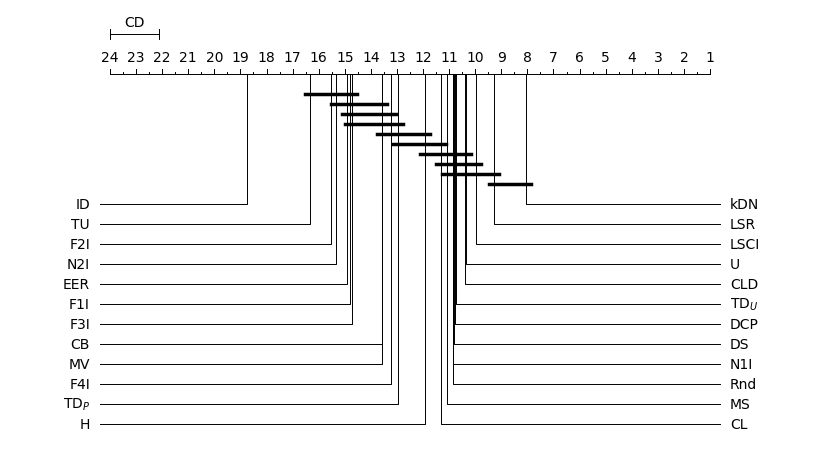

In [85]:
ax = plot_stats(autorank_result, width=8) 
fig = plt.gcf()
fig.savefig("nemenyi_auc.eps", format='eps')

Apesar das suspeitas que medidas tree-based são melhores para classificadores não baseados em arvore, só consigo dizer que TDu foi melhor que CART para SVM

## Análise por Iteração
---

In [86]:
def get_avg_ranks(results_df) -> pd.DataFrame:
    # Afere o kappa médio para cada query registrada
    avg_kappa = results_df.groupby(["classifier","method", "query", "dataset"]).kappa.mean()

    # Afere o rank de cada método para cada dataset
    ranks_df = avg_kappa.to_frame(name="kappa")
    ranks_df['rank'] = ranks_df.groupby(["query", "dataset"]).kappa.rank(ascending=False)

    # Calcula rank médio por query para cada 
    avg_ranks = ranks_df.groupby(["classifier", "method", "query"])["rank"].mean()
    return avg_ranks

In [87]:
avg_ranks_df = get_avg_ranks(results_df)

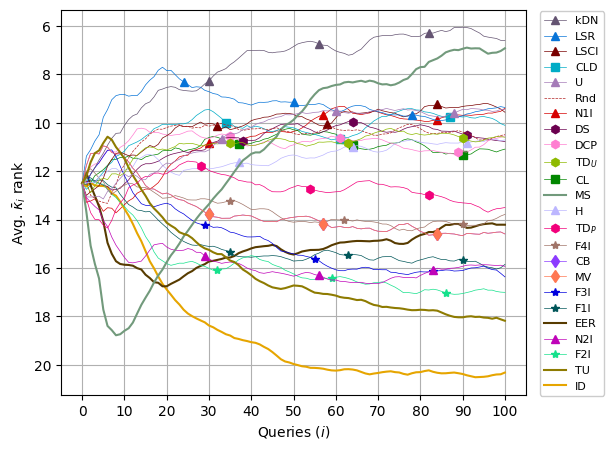

In [88]:
def plot_learning_curves(avg_ranks_df, classifier):

    fig, ax = plt.subplots(figsize=(6,5))
    ax.grid(True)
    ax.invert_yaxis()
    ax.set_xticks(np.arange(0,101,10))
    # ax.set_title(classifier)
    ax.set_xlabel("Queries ($i$)")
    ax.set_ylabel(r"Avg. $\bar\kappa_i$ rank")
    

    # Calcula rank médio por query para cada 
    clf_ranks = avg_ranks_df.loc[classifier]
    auc_scores = {}
    for method, data in clf_ranks.groupby("method", sort=False):

        # aplica média móvel nos dados:
        smoothed_data = data.rolling(window=5, min_periods=1).mean()

        auc_scores[utils.ABREV_DICT[method]] = np.trapz(smoothed_data)
        
        ax.plot(smoothed_data.values, utils.get_style(method),
                label=utils.ABREV_DICT.get(method), color=COLOR_DICT[method], markevery=(0.3, 0.2),
                linewidth=(0.5 if utils.get_hm_type(method) != 'classic' else 1.5) )
        
    handles, labels = plt.gca().get_legend_handles_labels()
    label_to_handle = {l: h for l, h in zip(labels, handles)}

    sorted_labels = sorted(auc_scores, key=auc_scores.get)
    plt.legend([label_to_handle[label] for label in sorted_labels],
               sorted_labels,
               loc='upper right', bbox_to_anchor=(1.18, 1.01), ncols=1, prop={'size': 8}, framealpha=1)

    return fig

fig = plot_learning_curves(avg_ranks_df, classifier="SVC")

fig.savefig(f'ranking_curve_SVM.eps',format="eps", bbox_inches='tight')